In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Paramètres ---
DATA_PATH = 'full_year.csv'
time_col = 'timestamp'

# Lecture initiale
df = pd.read_csv(DATA_PATH, parse_dates=[time_col])

# Widgets
start_picker = widgets.DatePicker(description='Date début', value=df[time_col].min().date())
end_picker   = widgets.DatePicker(description='Date fin',   value=df[time_col].max().date())

price_cols    = [c for c in df.columns if c.startswith('nodal_price_')]
regions       = sorted(c.replace('nodal_price_', '') for c in price_cols)
dispatch_cols = [c for c in df.columns if c.startswith('dispatch_')]
techs         = sorted({c.split('_')[1] for c in dispatch_cols})
flow_cols     = [c for c in df.columns if c.startswith('flow_out_')]

region_selector = widgets.SelectMultiple(options=regions, value=regions[:2], description='Régions')

# Pré-calcul des flux nets
for r in regions:
    inc = [c for c in flow_cols if c.endswith(f"_{r}")]
    out = [c for c in flow_cols if c.startswith(f"flow_out_{r}_")]
    df[f"net_flow_{r}"] = df[inc].sum(axis=1) - df[out].sum(axis=1)

def update_plots(start_date, end_date, selected_regions):
    clear_output(wait=True)
    display(widgets.HBox([start_picker, end_picker, region_selector]))

    mask = (df[time_col] >= pd.to_datetime(start_date)) & (df[time_col] <= pd.to_datetime(end_date))
    sub = df.loc[mask]

    # 1. Dispatch empilé
    for r in selected_regions:
        cols = [f"dispatch_{t}_{r}" for t in techs if f"dispatch_{t}_{r}" in sub]
        if not cols: continue
        piv = sub.set_index(time_col)[cols]
        piv.columns = [c.split('_')[1] for c in cols]
        fig = px.area(piv, title=f"Dispatch empilé — {r}", labels={'value':'MWh','index':'Temps'})
        fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
        fig.show()

    # 2. Flexibilité empilée
    for r in selected_regions:
        sc = [c for c in sub if c.startswith("storage_charge_")    and c.endswith(f"_{r}")]
        sd = [c for c in sub if c.startswith("storage_discharge_") and c.endswith(f"_{r}")]
        dr = f"demand_response_{r}"
        nf = f"net_flow_{r}"
        cols = sc + sd + ([dr] if dr in sub else []) + ([nf] if nf in sub else [])
        if not cols: continue
        piv = sub.set_index(time_col)[cols]
        rename = {}
        for c in sc: rename[c] = f"Charge {c.split('_')[2]}"
        for c in sd: rename[c] = f"Décharge {c.split('_')[2]}"
        if dr in cols: rename[dr] = "DR"
        if nf in cols: rename[nf] = "Flux net"
        piv.rename(columns=rename, inplace=True)
        fig = px.area(piv, title=f"Leviers de flexibilité — {r}", labels={'value':'MWh','index':'Temps'})
        fig.update_layout(xaxis=dict(rangeslider=dict(visible=True)))
        fig.show()

    # 3. Sankey inter-régional
    links = []
    for col in flow_cols:
        src, tgt = col.replace('flow_out_','').rsplit('_',1)
        if src in selected_regions and tgt in selected_regions:
            links.append({'source':src,'target':tgt,'value':sub[col].mean()})
    if links:
        nodes = list(selected_regions)
        idx = {n:i for i,n in enumerate(nodes)}
        fig = go.Figure(go.Sankey(
            node=dict(label=nodes,pad=15),
            link=dict(
                source=[idx[l['source']] for l in links],
                target=[idx[l['target']] for l in links],
                value=[l['value'] for l in links]
            )
        ))
        fig.update_layout(title="Flux moyens inter-régionaux", font_size=12)
        fig.show()

    # 4. Prix vs flux net
    for r in selected_regions:
        pc, nf = f"nodal_price_{r}", f"net_flow_{r}"
        if pc in sub and nf in sub:
            dff = sub.dropna(subset=[pc,nf])
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=dff[time_col], y=dff[pc], name="Prix nodal"))
            fig.add_trace(go.Scatter(x=dff[time_col], y=dff[nf], name="Flux net", yaxis="y2"))
            fig.update_layout(
                title=f"Prix nodal vs Flux net — {r}",
                xaxis=dict(rangeslider=dict(visible=True)),
                yaxis=dict(title="Prix (€/MWh)"),
                yaxis2=dict(title="Flux (MWh)", overlaying="y", side="right")
            )
            fig.show()

    # 5. DR vs stockage
    for r in selected_regions:
        drc = f"demand_response_{r}"
        sc0 = next((c for c in sub if c.startswith("storage_charge_") and c.endswith(f"_{r}")), None)
        if drc in sub and sc0:
            fig = px.scatter(sub, x=drc, y=sc0, trendline="ols",
                             title=f"DR vs Charge stockage — {r}",
                             labels={drc:"DR", sc0:"Charge stockage"})
            fig.show()

    # --- Nouveaux graphiques ---

    # 6. Profil journalier moyen de la DR (agrégation par heure)
    for r in selected_regions:
        drc = f"demand_response_{r}"
        if drc in sub:
            tmp = sub.copy()
            tmp['hour'] = tmp[time_col].dt.hour
            mean_dr = tmp.groupby('hour')[drc].mean().reset_index()
            fig = px.line(mean_dr, x='hour', y=drc,
                          title=f"Profil moyen journalier DR — {r}",
                          labels={'hour':'Heure', drc:'DR moyen (MWh)'})
            fig.show()

    # 7. Box plot de la dispatch par technologie (toutes régions)
    disp = sub[[time_col] + [c for c in sub if c.startswith('dispatch_')]]
    disp_melt = disp.melt(id_vars=time_col, var_name='metric', value_name='value')
    disp_melt['tech'] = disp_melt['metric'].str.split('_').str[1]
    fig = px.box(disp_melt, x='tech', y='value',
                 title="Distribution de dispatch par technologie",
                 labels={'value':'MWh','tech':'Technologie'})
    fig.show()

    # 8. Matrice de corrélation des leviers (DR, stockage, flux) pour une région
    for r in selected_regions:
        cols = [f"demand_response_{r}"] + \
               [c for c in sub if c.startswith("storage_charge_") and c.endswith(f"_{r}")] + \
               [c for c in sub if c.startswith("storage_discharge_") and c.endswith(f"_{r}")] + \
               [f"net_flow_{r}"]
        df_corr = sub[cols].corr()
        fig = px.imshow(df_corr, text_auto=True,
                        title=f"Corrélation leviers — {r}",
                        labels=dict(x="Variable", y="Variable", color="Corrélation"))
        fig.show()

# Affichage interactif
ui = widgets.HBox([start_picker, end_picker, region_selector])
out = widgets.interactive_output(update_plots, {
    'start_date': start_picker,
    'end_date': end_picker,
    'selected_regions': region_selector
})
display(ui, out)


Output()

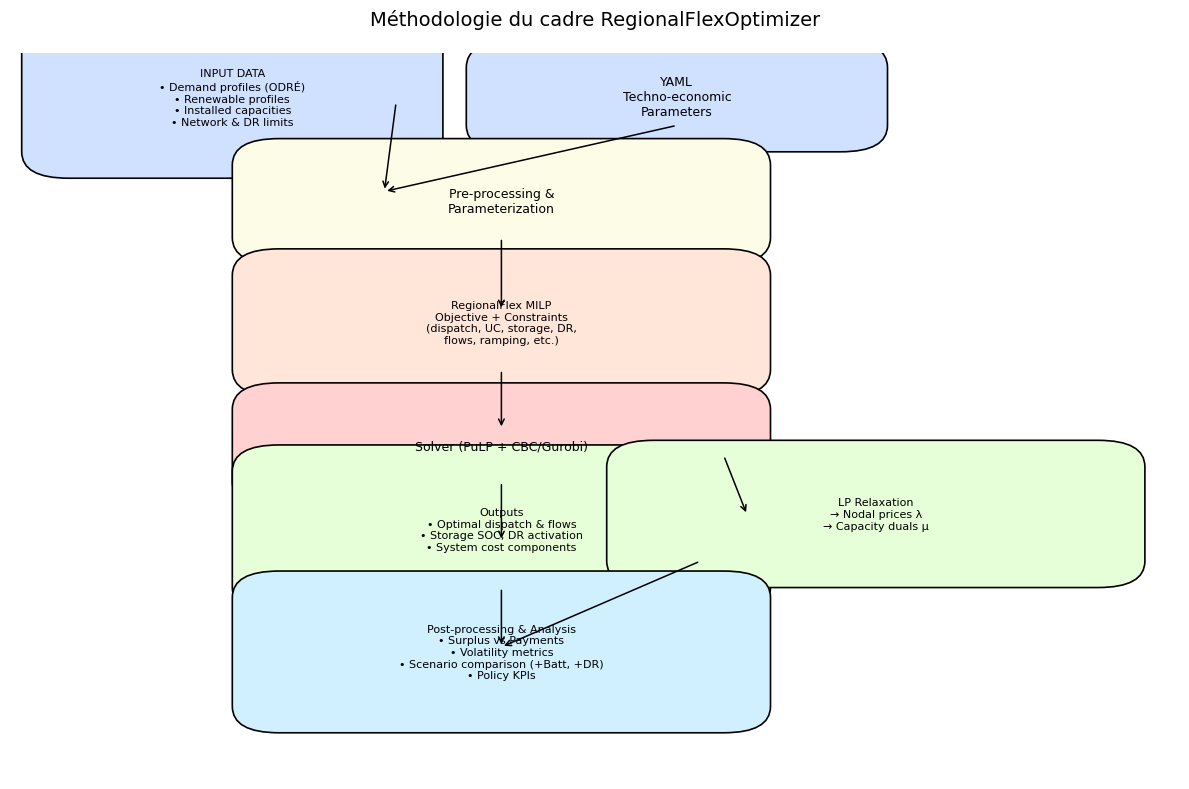

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
import matplotlib.lines as mlines

def add_box(ax, x, y, w, h, text, fc="white", fontsize=9):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.4", 
                         edgecolor="black", facecolor=fc, linewidth=1.2)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=fontsize, wrap=True)

def add_arrow(ax, x1, y1, x2, y2):
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", lw=1.1))

fig, ax = plt.subplots(figsize=(12, 8))

# Box dimensions
w, h = 2.8, 1.1

# 1. Input data
add_box(ax, 0.5, 6.5, w, h*1.5,
        "INPUT DATA\n• Demand profiles (ODRÉ)\n• Renewable profiles\n• Installed capacities\n• Network & DR limits",
        fc="#d0e1ff", fontsize=8)

# 1b YAML config
add_box(ax, 4.3, 6.9, w, h*0.8, "YAML\nTechno‑economic\nParameters", fc="#d0e1ff")

# Arrow to preprocessing
add_arrow(ax, 0.5 + w, 7.25, 3.2, 5.9)
add_arrow(ax, 4.3 + w/2, 6.9, 3.2, 5.9)

# 2. Pre‑processing
add_box(ax, 2.3, 5.2, w+1, h,
        "Pre‑processing &\nParameterization", fc="#fdfde7")

# Arrow to MILP
add_arrow(ax, 2.3 + (w+1)/2, 5.2, 2.3 + (w+1)/2, 4.1)

# 3. MILP formulation
add_box(ax, 2.3, 3.2, w+1, h*1.3,
        "RegionalFlex MILP\nObjective + Constraints\n(dispatch, UC, storage, DR,\nflows, ramping, etc.)",
        fc="#ffe6d9", fontsize=8)

# Arrow to solver
add_arrow(ax, 2.3 + (w+1)/2, 3.2, 2.3 + (w+1)/2, 2.3)

# 4. Solver
add_box(ax, 2.3, 1.5, w+1, h,
        "Solver (PuLP + CBC/Gurobi)", fc="#ffd1d1")

# Arrow to Outputs
add_arrow(ax, 2.3 + (w+1)/2, 1.5, 2.3 + (w+1)/2, 0.6)

# LP relaxation branch arrow
add_arrow(ax, 2.3 + (w+1), 1.9, 6.3, 1.0)

# 5. Outputs
add_box(ax, 2.3, -0.1, w+1, h*1.6,
        "Outputs\n• Optimal dispatch & flows\n• Storage SOC, DR activation\n• System cost components",
        fc="#e7ffd9", fontsize=8)

# 6. Dual / Prices block (from LP relaxation)
add_box(ax, 5.5, 0.3, w+1, h*1.3,
        "LP Relaxation\n→ Nodal prices λ\n→ Capacity duals μ", fc="#e7ffd9", fontsize=8)

# Arrow from outputs to analysis
add_arrow(ax, 2.3 + (w+1)/2, -0.1, 2.3 + (w+1)/2, -1.0)
# Arrow from duals to analysis
add_arrow(ax, 5.5 + 0.4, 0.3, 2.3 + (w+1)/2, -1.0)

# 7. Analysis / Visualization
add_box(ax, 2.3, -1.9, w+1, h*1.5,
        "Post‑processing & Analysis\n• Surplus vs Payments\n• Volatility metrics\n• Scenario comparison (+Batt, +DR)\n• Policy KPIs",
        fc="#d0f0ff", fontsize=8)

# Formatting
ax.set_xlim(0, 10)
ax.set_ylim(-3, 8)
ax.axis('off')
plt.title("Méthodologie du cadre RegionalFlexOptimizer", fontsize=14, pad=20)
plt.tight_layout()
plt.show()
